## Импорт необходимых библиотек

In [235]:
import numpy as np
import pandas as pd
from scipy.stats import norm, mannwhitneyu
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

sns.set(rc={'figure.figsize': (20, 7)},
        font_scale=2)

## Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа



In [236]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

## Считывание и преобразование данных

In [237]:
df = pd.read_csv('hw_bootstrap.csv', sep=';')
df.drop(columns='Unnamed: 0', inplace=True)
df['value'] = df.value.str.replace(',', '.').astype(float)

In [238]:
df.shape

(1000, 2)

In [239]:
df.dtypes

value                float64
experimentVariant     object
dtype: object

In [240]:
df.head()

,value,experimentVariant
0,10.380495,Control
1,9.546867,Control
2,11.088215,Control
3,10.147274,Control
4,9.789808,Control


In [241]:
# разделяем значения контрольной и тестовой группы по соответстующим переменным
control_data = df.query("experimentVariant == 'Control'").value
test_data = df.query("experimentVariant == 'Treatment'").value

## Применение U-критерия Манна-Уитни

In [242]:
# применяем критерий Манна Уитни 
stat, p = mannwhitneyu(control_data, test_data)
print('Statistics=%.3f, p=%.3f' % (stat, p))

alpha = 0.05
if p > alpha:
    print('Нет основний отклонять нулевую гипотезу')
else:
    print('Есть основния отклонять нулевую гипотезу')

Statistics=124189.500, p=0.430
Нет основний отклонять нулевую гипотезу


## Посмотрим, что покажет bootstrap, используя среднее по бут-выборкам.

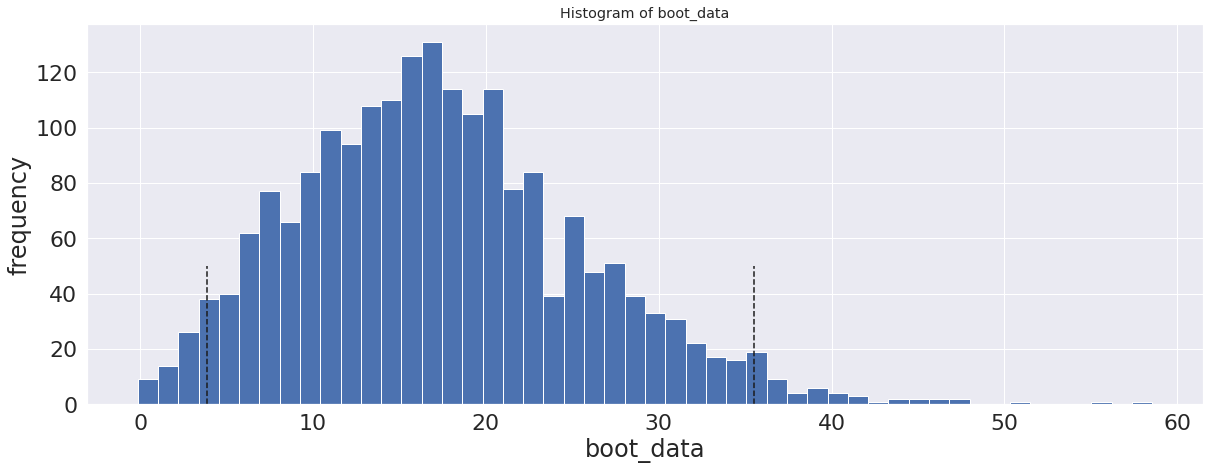

In [243]:
booted_data = get_bootstrap(test_data, control_data, boot_it = 2000)

In [244]:
booted_data['p_value']

0.03640345909412717

In [245]:
booted_data['ci']

,0
0.025,3.885457
0.975,35.503130


### Так как 0 не попал в доверительный интервал и p-value оказалось меньше 0.05, то мы имеем основания отклонить нулевую гипотезу об отсутствии значимых различий между тестовой и контрольной группами. 
### Довольно странная ситуация, учитывая результаты U-критерия.
## Стоит посмотреть на распределение медиан.

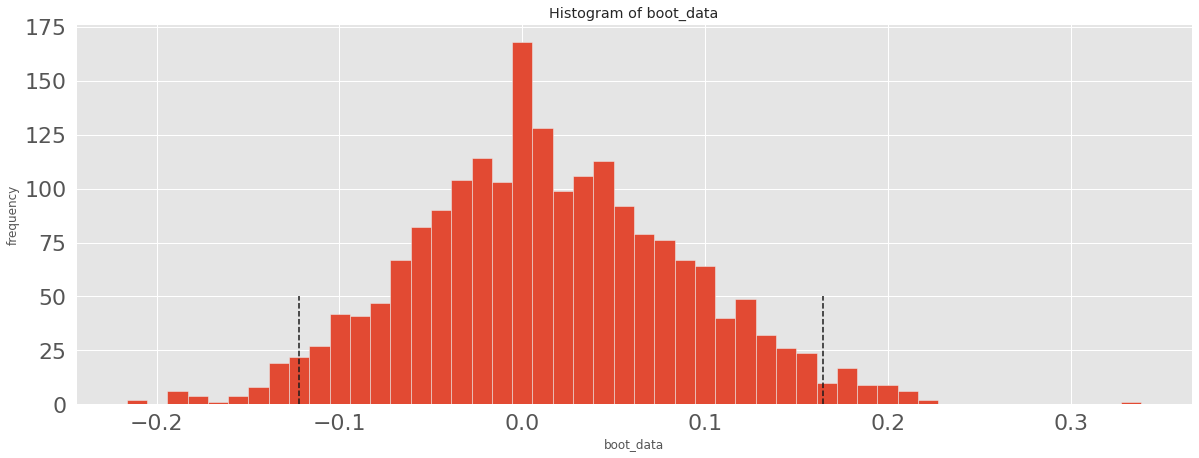

In [246]:
booted_data = get_bootstrap(test_data, control_data, boot_it = 2000, statistic=np.median)

In [247]:
booted_data['p_value']

0.8441842559467603

In [248]:
booted_data['ci']

,0
0.025,-0.122247
0.975,0.164493


### Здесь мы наблюдаем абсолютно противоположную ситуцию. Нет оснований отклонить нулевую гипотезу, так как 0 входит в доверительный интервал, а p-value больше 0.05
### Уже понятно, что мы имеем дело с большими выбросами, наличие которых делает расчет среднего некорректным.

## Стоит посмотреть на графики

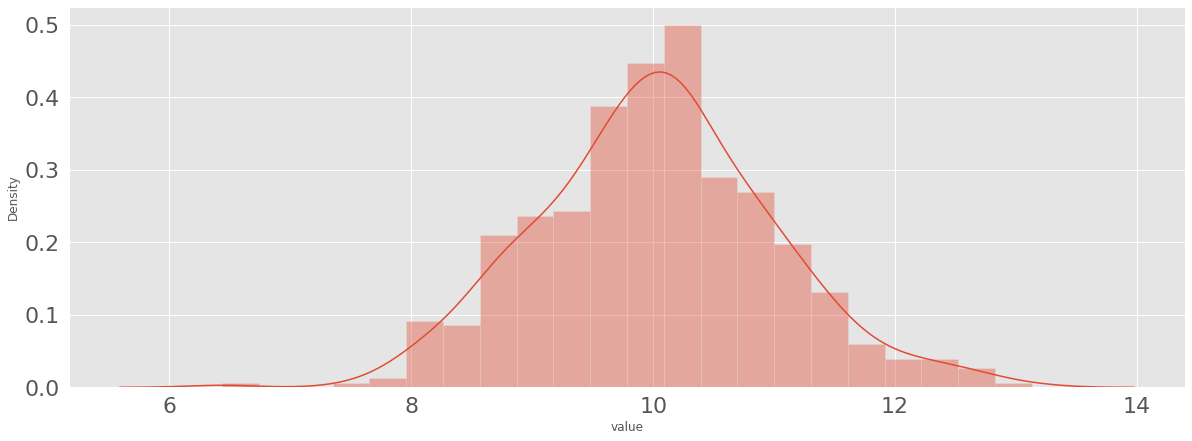

In [253]:
sns.distplot(control_data)
# распределение контрольных значений

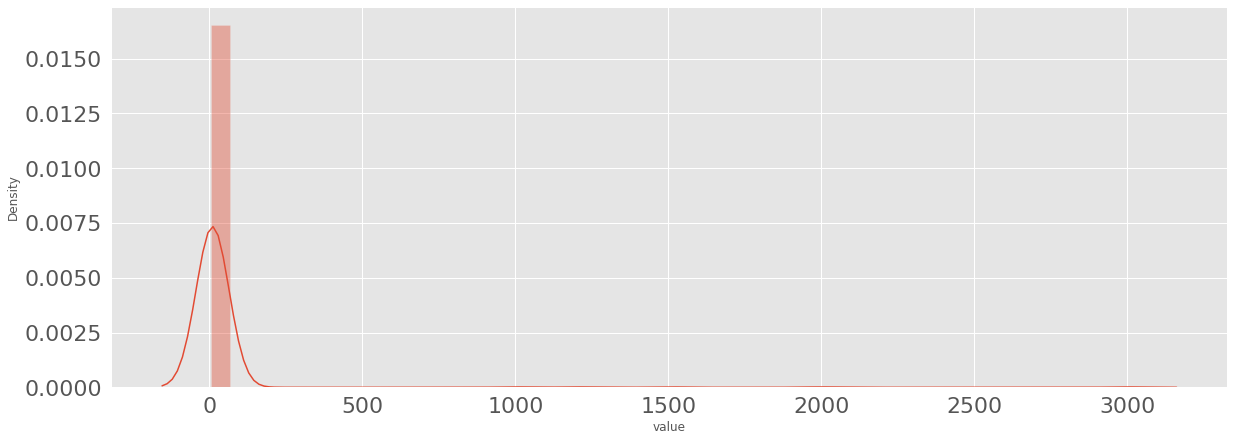

In [252]:
sns.distplot(test_data)
# распределение тестовых значений

## Заметим, что график распределения значений тестовой группы очень странный. Попробую 2 варианта: 
## 1. Логарифмирование.
## 2. Проверка на выбросы и избавление от них.

### Посмотрим на логарифмированные распределение контрольных и тестовых значений

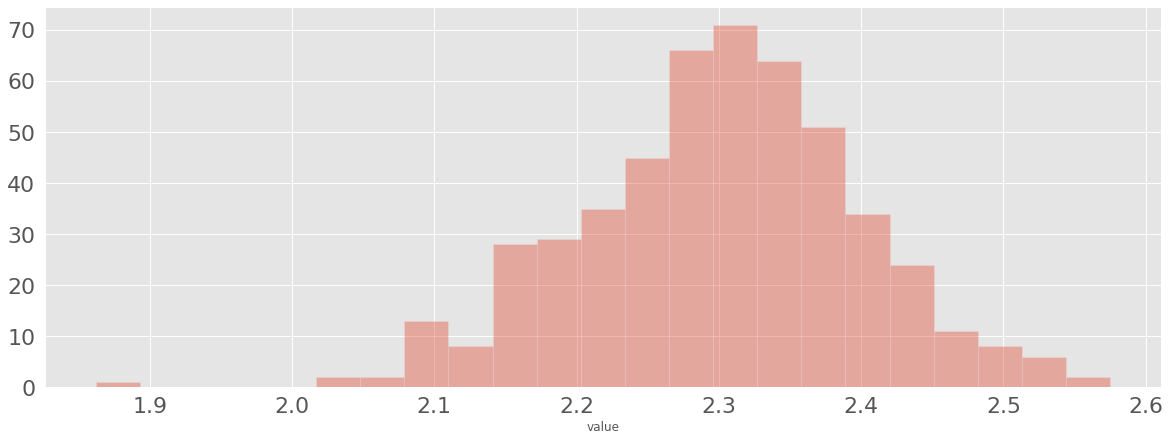

In [254]:
sns.distplot(np.log(control_data), kde=False)
# контрольная группа

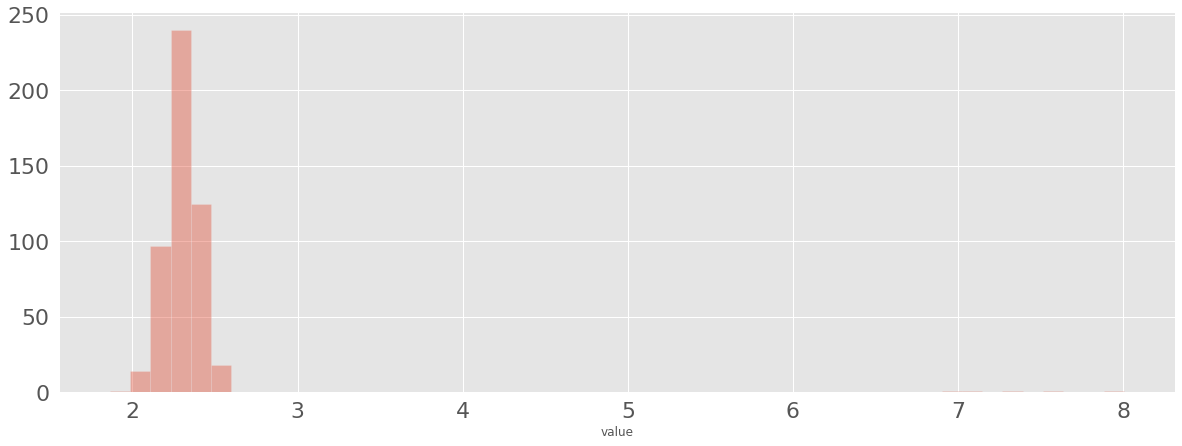

In [255]:
sns.distplot(np.log(test_data), kde=False)
# тестовая группа

### Это выглядит лучше, но распределения кардинально различаются. 

### Значит дело точно в больших выбросах.

In [256]:
# Посчитаем среднее и медиану в каждой группе
print(f'Среднее в контрольной группе = {control_data.mean()} \nМедиана в контрольной группе = {control_data.median()}\n\nСреднее в тестовой группе = {test_data.mean()}\nМедиана в тестовой группе = {test_data.median()}')

Среднее в контрольной группе = 10.026866533804297 
Медиана в контрольной группе = 10.0184651909296

Среднее в тестовой группе = 27.321499056661573
Медиана в тестовой группе = 10.02584684253515


### В тестовой группе имеется немаленькая разница между средним и медианой. Это говорит о том, что мы точно имеем дело с выбросами.

In [257]:
test_data.loc[test_data > 14]
# вот и они

995    1000.0
996    1200.0
997    1500.0
998    2000.0
999    3000.0
Name: value, dtype: float64

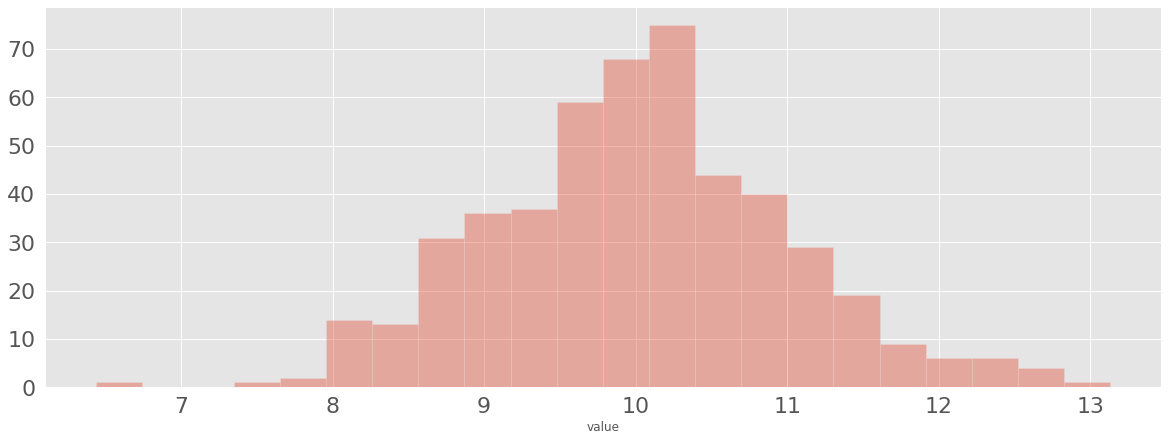

In [258]:
# избавляемся от выбросов 
test_data = test_data.loc[test_data < 14]
# и визуализируем
sns.distplot(test_data, kde=False)

### Проблема решена.

## Делаем bootstrap, используя среднее по бут-выборкам после избавления от выбросов для подтверждения моего подозрения о том, что проблема была именно в них.

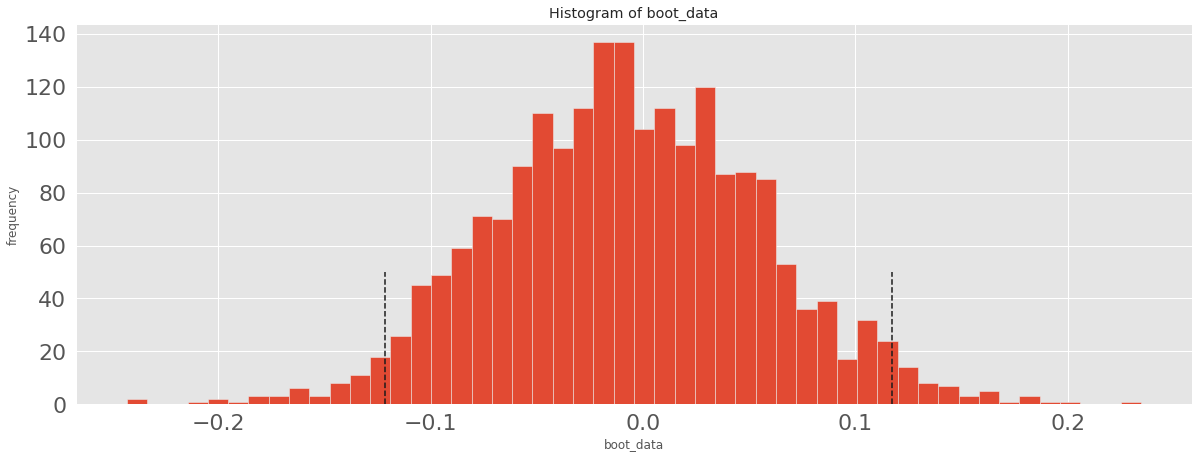

In [259]:
booted_data = get_bootstrap(test_data, control_data, boot_it = 2000)

In [261]:
booted_data['p_value']

0.9113744829275714

In [262]:
booted_data['ci']

,0
0.025,-0.121755
0.975,0.117119


### Проблема решена. Теперь показания критерия Манна-Уитни понятны.

## Мое заключение: 
## Мы не имеем основания полагать, что данные тестовой и контрольной группы значимо различаются, так как 0 входит в доверительный интервал, а p-value оказался значительно больше 0.05